In [2]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.6 MB/s eta 0:00:00


Found 6355 images belonging to 15 classes.
Found 270 images belonging to 15 classes.
16804768/16804768 [==============================] - 0s 0us/step
Epoch 1/50


2023-09-29 15:03:34.845473: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnet-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


199/199 [==============================] - 130s 417ms/step - loss: 0.7289 - accuracy: 0.8411 - val_loss: 1.3103 - val_accuracy: 0.8148
Epoch 2/50
199/199 [==============================] - 42s 208ms/step - loss: 0.2978 - accuracy: 0.9511 - val_loss: 9.0374 - val_accuracy: 0.5630
Epoch 3/50
199/199 [==============================] - 43s 214ms/step - loss: 0.3537 - accuracy: 0.9300 - val_loss: 0.0836 - val_accuracy: 0.9815
Epoch 4/50
199/199 [==============================] - 42s 211ms/step - loss: 0.2301 - accuracy: 0.9671 - val_loss: 1.3340 - val_accuracy: 0.8074
Epoch 5/50
199/199 [==============================] - 42s 211ms/step - loss: 0.1205 - accuracy: 0.9751 - val_loss: 0.2375 - val_accuracy: 0.9556
Epoch 6/50
199/199 [==============================] - 43s 215ms/step - loss: 0.0947 - accuracy: 0.9836 - val_loss: 0.2631 - val_accuracy: 0.9593
Epoch 7/50
199/199 [==============================] - 43s 213ms/step - loss: 0.1399 - accuracy: 0.9758 - val_loss: 0.9369 - val_accuracy: 0.

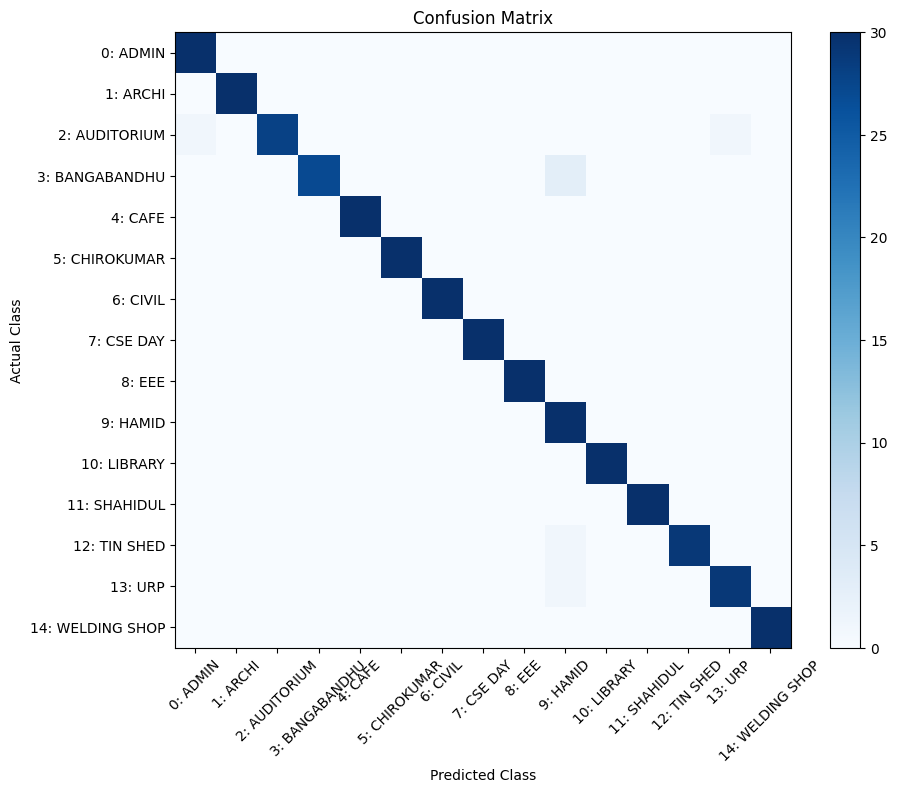

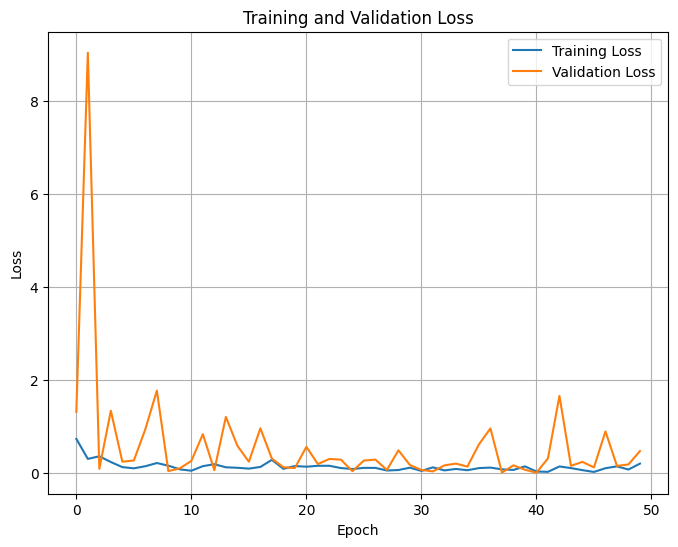

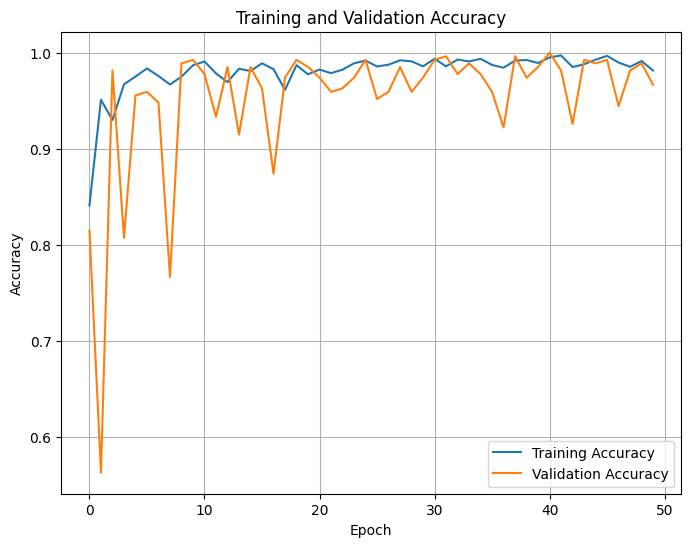

In [3]:
#"Model Training"

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, accuracy_score
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from efficientnet.tfkeras import EfficientNetB0  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory('/kaggle/input/dataset-ruet/basedata/basedata/training', target_size=(224, 224), batch_size=32, class_mode='categorical')
valid_generator = valid_datagen.flow_from_directory('/kaggle/input/dataset-ruet/basedata/basedata/validation', target_size=(224, 224), batch_size=32, class_mode='categorical')

efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential()
model.add(efficientnet_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(15, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_generator, epochs=50, validation_data=valid_generator)

model_dir = '/kaggle/working/model_study/EfficientNetB0'
os.makedirs(model_dir, exist_ok=True)

model.save(os.path.join(model_dir, 'my_model_EfficientNetB0.h5'))

loss_values = np.array(history.history['loss']).reshape(-1, 1)
accuracy_values = np.array(history.history['accuracy']).reshape(-1, 1)
val_loss_values = np.array(history.history['val_loss']).reshape(-1, 1)
val_accuracy_values = np.array(history.history['val_accuracy']).reshape(-1, 1)

file_name = 'EfficientNetB0.csv'

results = np.column_stack((loss_values, accuracy_values, val_loss_values, val_accuracy_values))

csv_file_path = os.path.join(model_dir, file_name)
np.savetxt(csv_file_path, results, delimiter=',', header='Loss,Accuracy,Validation Loss,Validation Accuracy', comments='')

print("Loss values:", loss_values)
print("Accuracy values:", accuracy_values)
print("Validation loss values:", val_loss_values)
print("Validation accuracy values:", val_accuracy_values)

print("CSV file saved at:", csv_file_path)


#"Testing/Prediction"

test_data_dir = '/kaggle/input/dataset-ruet/basedata/basedata/testing'
test_images = []
ground_truth_labels = []
for class_name in os.listdir(test_data_dir):
    class_dir = os.path.join(test_data_dir, class_name)
    for image_file in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_file)
        img = image.load_img(image_path, target_size=(224, 224))  
        img_array = image.img_to_array(img)
        img_array /= 255.0
        test_images.append(img_array)
        ground_truth_labels.append(class_name)

test_images = np.array(test_images)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

label_to_index = {label: i for i, label in enumerate(train_generator.class_indices)}
ground_truth_indices = np.array([label_to_index[label] for label in ground_truth_labels])

class_names = list(train_generator.class_indices.keys())
class_numbers = [label_to_index[label] for label in class_names]

conf_matrix = confusion_matrix(ground_truth_indices, predicted_labels)

accuracy = accuracy_score(ground_truth_indices, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)

plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.colorbar()
tick_marks = np.arange(len(train_generator.class_indices))
plt.xticks(tick_marks, [f"{class_numbers[i]}: {class_names[i]}" for i in tick_marks], rotation=45)
plt.yticks(tick_marks, [f"{class_numbers[i]}: {class_names[i]}" for i in tick_marks])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(accuracy_values, label='Training Accuracy')
plt.plot(val_accuracy_values, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid()
plt.show()




In [4]:
#"Performance Matrix Calculation"

from sklearn.metrics import confusion_matrix, accuracy_score

num_classes = conf_matrix.shape[0]

precisions = []
recalls = []
f1_scores = []

for i in range(num_classes):
    true_positives = conf_matrix[i, i]
    false_positives = np.sum(conf_matrix[:, i]) - true_positives
    false_negatives = np.sum(conf_matrix[i, :]) - true_positives

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    
    if precision == 0 and recall == 0:
        f1_score = 0.0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

print("Class Precisions:", precisions)
print("Class Recalls:", recalls)
print("Class F1 Scores:", f1_scores)

from sklearn.metrics import precision_score, recall_score, f1_score

micro_precision = precision_score(ground_truth_indices, predicted_labels, average='micro')
micro_recall = recall_score(ground_truth_indices, predicted_labels, average='micro')
micro_f1 = f1_score(ground_truth_indices, predicted_labels, average='micro')
print("Micro-Precision:", micro_precision)
print("Micro-Recall:", micro_recall)
print("Micro-F1:", micro_f1)

top_1_accuracy = accuracy_score(ground_truth_indices, predicted_labels)
top_5_predictions = np.argsort(predictions, axis=1)[:, -5:]  
top_5_accuracy = np.mean(np.array([ground_truth_indices[i] in top_5_predictions[i] for i in range(len(ground_truth_indices))]))

print("Top-1 Accuracy:", top_1_accuracy)
print("Top-5 Accuracy:", top_5_accuracy)


Class Precisions: [0.967741935483871, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 0.9666666666666667, 1.0]
Class Recalls: [1.0, 1.0, 0.9333333333333333, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9666666666666667, 0.9666666666666667, 1.0]
Class F1 Scores: [0.9836065573770492, 1.0, 0.9655172413793104, 0.9473684210526316, 1.0, 1.0, 1.0, 1.0, 1.0, 0.923076923076923, 1.0, 1.0, 0.983050847457627, 0.9666666666666667, 1.0]
Micro-Precision: 0.9844444444444445
Micro-Recall: 0.9844444444444445
Micro-F1: 0.9844444444444445
Top-1 Accuracy: 0.9844444444444445
Top-5 Accuracy: 0.9977777777777778


In [6]:
#"Performance Matrix Calculation"

from sklearn.metrics import confusion_matrix, accuracy_score

num_classes = conf_matrix.shape[0]

class_metrics = []
precisions = []
recalls = []
f1_scores = []
accuracies = []

for i in range(num_classes):
    true_positives = conf_matrix[i, i]
    false_positives = np.sum(conf_matrix[:, i]) - true_positives
    false_negatives = np.sum(conf_matrix[i, :]) - true_positives

    true_negatives = np.sum(conf_matrix) - true_positives - false_positives - false_negatives

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
   
    if precision == 0 and recall == 0:
        f1_score = 0.0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    accuracy = (true_positives + true_negatives) / np.sum(conf_matrix)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)
    accuracies.append(accuracy)

    class_metrics.append({
        'Class': i + 1,
        'True Positives': true_positives,
        'True Negatives': true_negatives,
        'False Positives': false_positives,
        'False Negatives': false_negatives,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'Accuracy': accuracy
    })

average_precision = sum(precisions) / len(precisions)
average_recall = sum(recalls) / len(recalls)
average_f1_score = sum(f1_scores) / len(f1_scores)
average_accuracy = sum(accuracies) / len(accuracies)

print("Class Metrics:")
for metrics in class_metrics:
    print(f"Class {metrics['Class']} - Precision: {metrics['Precision']}, Recall: {metrics['Recall']}, F1 Score: {metrics['F1 Score']}, Accuracy: {metrics['Accuracy']}")
    print(f"TTP: {metrics['True Positives']}, TTN: {metrics['True Negatives']}, TFP: {metrics['False Positives']}, TFN: {metrics['False Negatives']}")
    print("")

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)
print("Average F1 Score:", average_f1_score)
print("Average Accuracy:", average_accuracy)


Class Metrics:
Class 1 - Precision: 0.967741935483871, Recall: 1.0, F1 Score: 0.9836065573770492, Accuracy: 0.9977777777777778
TTP: 30, TTN: 419, TFP: 1, TFN: 0

Class 2 - Precision: 1.0, Recall: 1.0, F1 Score: 1.0, Accuracy: 1.0
TTP: 30, TTN: 420, TFP: 0, TFN: 0

Class 3 - Precision: 1.0, Recall: 0.9333333333333333, F1 Score: 0.9655172413793104, Accuracy: 0.9955555555555555
TTP: 28, TTN: 420, TFP: 0, TFN: 2

Class 4 - Precision: 1.0, Recall: 0.9, F1 Score: 0.9473684210526316, Accuracy: 0.9933333333333333
TTP: 27, TTN: 420, TFP: 0, TFN: 3

Class 5 - Precision: 1.0, Recall: 1.0, F1 Score: 1.0, Accuracy: 1.0
TTP: 30, TTN: 420, TFP: 0, TFN: 0

Class 6 - Precision: 1.0, Recall: 1.0, F1 Score: 1.0, Accuracy: 1.0
TTP: 30, TTN: 420, TFP: 0, TFN: 0

Class 7 - Precision: 1.0, Recall: 1.0, F1 Score: 1.0, Accuracy: 1.0
TTP: 30, TTN: 420, TFP: 0, TFN: 0

Class 8 - Precision: 1.0, Recall: 1.0, F1 Score: 1.0, Accuracy: 1.0
TTP: 30, TTN: 420, TFP: 0, TFN: 0

Class 9 - Precision: 1.0, Recall: 1.0, F1 

In [7]:
#"Results Visualization"

import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score

num_classes = conf_matrix.shape[0]
class_names = [
    'ADMIN', 'ARCHI', 'AUDITORIUM', 'BANGABANDHU', 'CAFE',
    'CHIROKUMAR', 'CIVIL', 'CSE DAY', 'EEE', 'HAMID',
    'LIBRARY', 'SHAHIDUL', 'TIN SHED', 'URP', 'WELDING SHOP'
]

class_metrics = []
precisions = []
recalls = []
f1_scores = []
accuracies = []

for i in range(num_classes):
    true_positives = conf_matrix[i, i]
    false_positives = np.sum(conf_matrix[:, i]) - true_positives
    false_negatives = np.sum(conf_matrix[i, :]) - true_positives

    true_negatives = np.sum(conf_matrix) - true_positives - false_positives - false_negatives

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
   
    if precision == 0 and recall == 0:
        f1_score = 0.0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    accuracy = (true_positives + true_negatives) / np.sum(conf_matrix)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)
    accuracies.append(accuracy)
    
    class_metrics.append({
        'Class': class_names[i],
        'TTP': true_positives,
        'TTN': true_negatives,
        'TFP': false_positives,
        'TFN': false_negatives,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'Accuracy': accuracy
    })

average_precision = sum(precisions) / len(precisions)
average_recall = sum(recalls) / len(recalls)
average_f1_score = sum(f1_scores) / len(f1_scores)
average_accuracy = sum(accuracies) / len(accuracies)

class_metrics.append({
    'Class': 'Average',
    'TTP': '',  
    'TTN': '',
    'TFP': '',
    'TFN': '',
    'Precision': average_precision,
    'Recall': average_recall,
    'F1 Score': average_f1_score,
    'Accuracy': average_accuracy
})

metrics_df = pd.DataFrame(class_metrics)

metrics_df = metrics_df[['Class', 'TTP', 'TTN', 'TFP', 'TFN', 'Precision', 'Recall', 'F1 Score', 'Accuracy']]

print(metrics_df)


           Class TTP  TTN TFP TFN  Precision    Recall  F1 Score  Accuracy
0          ADMIN  30  419   1   0   0.967742  1.000000  0.983607  0.997778
1          ARCHI  30  420   0   0   1.000000  1.000000  1.000000  1.000000
2     AUDITORIUM  28  420   0   2   1.000000  0.933333  0.965517  0.995556
3    BANGABANDHU  27  420   0   3   1.000000  0.900000  0.947368  0.993333
4           CAFE  30  420   0   0   1.000000  1.000000  1.000000  1.000000
5     CHIROKUMAR  30  420   0   0   1.000000  1.000000  1.000000  1.000000
6          CIVIL  30  420   0   0   1.000000  1.000000  1.000000  1.000000
7        CSE DAY  30  420   0   0   1.000000  1.000000  1.000000  1.000000
8            EEE  30  420   0   0   1.000000  1.000000  1.000000  1.000000
9          HAMID  30  415   5   0   0.857143  1.000000  0.923077  0.988889
10       LIBRARY  30  420   0   0   1.000000  1.000000  1.000000  1.000000
11      SHAHIDUL  30  420   0   0   1.000000  1.000000  1.000000  1.000000
12      TIN SHED  29  420